In [3]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys()

#symbols = ["ETH/USD", "DOGE/USD", "BTC/USD"]
symbols = ["AAPL", "GOOGL", "MSFT"]
prices = pd.DataFrame()
for sym in symbols: 
    SYMBOL = sym 
    SYM_HIST_FILE = f'./{sym.replace("/", "_")}.csv'

    stk = cira.Stock(sym)

    if not exists(SYM_HIST_FILE): # chacheing historical data  
        start = datetime(2021, 1, 1).date()
        end = datetime.now().date()
        stk.save_historical_data(SYM_HIST_FILE, start, end)

    data = stk.load_historical_data(SYM_HIST_FILE)
    prices[sym.split("/")[0]] = data["open"]

#prices["USD"] = 1.0
#annual_inflation_rate = 0.033  # 3.3%

# Convert the annual inflation rate to a daily inflation rate
#daily_inflation_rate = np.power(1 + annual_inflation_rate, 1/365) - 1

#prices['USD'] = prices['USD'] * (1 - daily_inflation_rate) ** np.arange(len(prices))
prices.head()

,AAPL,GOOGL,MSFT
timestamp,,,
2016-01-04 05:00:00+00:00,23.26,38.07,48.10
2016-01-05 05:00:00+00:00,23.97,38.16,48.64
2016-01-06 05:00:00+00:00,22.79,37.48,48.10
2016-01-07 05:00:00+00:00,22.37,37.28,46.66
2016-01-08 05:00:00+00:00,22.34,37.35,46.37


<Axes: xlabel='timestamp'>

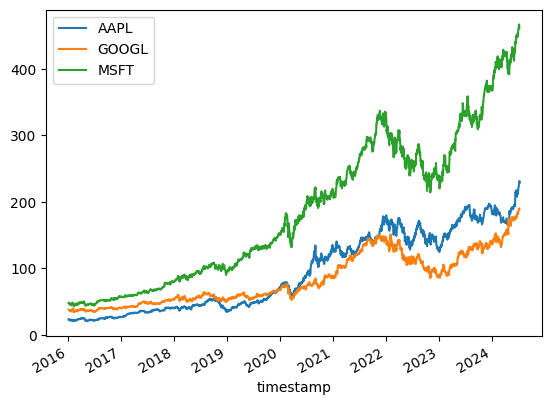

In [4]:
prices.plot()

In [5]:
split_prc = 0.7
train_data = prices.iloc[:int(len(prices)*split_prc)]
test_data =  prices.iloc[int(len(prices)*split_prc):]
print(len(prices), len(train_data), len(test_data))
assert len(prices) == len(train_data) + len(test_data)

2145 1501 644


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim



class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Agent:
    def __init__(self, epsilon=0.1):
        self.model = PolicyNetwork()
        self.optimizer = optim.Adam(self.model.parameters())
        self.epsilon = epsilon

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        if np.random.rand() < self.epsilon:
            action = np.random.choice(3)  # choose a random action
        else:
            action_probs = self.model(state)
            action = torch.argmax(action_probs).item()  # choose the best action
        return action
    
    
    def update_policy(self, state, action, reward):
        self.optimizer.zero_grad()
        state = torch.tensor(state, dtype=torch.float32)
        action_probs = self.model(state)
        loss = -torch.log(action_probs[action]) * reward
        loss.backward()
        self.optimizer.step()


In [7]:

agent = Agent(0.7)
train_data.values

array([[ 23.26,  38.07,  48.1 ],
       [ 23.97,  38.16,  48.64],
       [ 22.79,  37.48,  48.1 ],
       ...,
       [172.58, 143.8 , 326.01],
       [172.44, 143.25, 321.5 ],
       [176.55, 147.  , 328.45]])

In [8]:
actions = [] 
for t in range(len(train_data)-1):
    state = train_data.iloc[t].values
    action = agent.get_action(state)
    actions.append(action)
    next_state = train_data.iloc[t+1].values
    reward = next_state[action] - state[action]
    agent.update_policy(state, action, reward)
pd.DataFrame({"actions":actions}).value_counts()

actions
0          794
1          356
2          350
Name: count, dtype: int64

In [15]:
from numpy import ndarray
from pandas import DataFrame


class PolicyNetworkStrategy(cira.strategy.Strategy):
    def __init__(self, agent:Agent, allocation_amt = 0.1) -> None:
        super().__init__(name="PolicyNetwork")
        self.agent = agent
        self.allocation_amt = allocation_amt
        self.allocations = []

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash=float) -> ndarray: 
        actions = [] 
        for t in range(len(prices)-1):
            state = prices.iloc[t].values
            action = agent.get_action(state)
            actions.append(action)
            next_state = prices.iloc[t+1].values
            reward = next_state[action] - state[action]
            agent.update_policy(state, action, reward)
        _all = np.array([0,0,0])
        if actions == []: 
            pass
        else: 
            action = actions[-1]
            _all[action] = ( cash/prices.iloc[-1].to_list()[action] ) * self.allocation_amt 
        self.allocations.append(_all)
        _all[np.isnan(_all)] = 0.0
        return _all.astype(float) 




<Axes: xlabel='timestamp'>

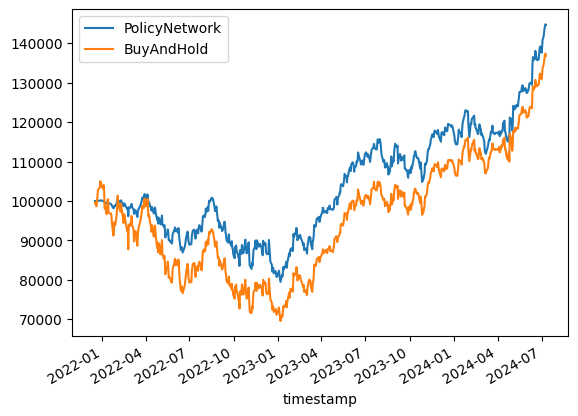

In [16]:
from cira.strategy import back_test_against_buy_and_hold, back_test
strat = PolicyNetworkStrategy(agent, allocation_amt=0.01)
back_test_against_buy_and_hold(strat, test_data, test_data, 100_000 ).plot()

<Axes: >

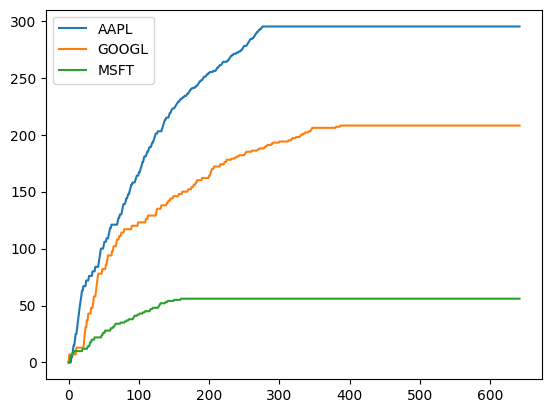

In [17]:
from collections import defaultdict
all_allocations = defaultdict(list)
for _all in strat.allocations:
    for i, sym in enumerate(test_data.keys()):
        all_allocations[sym].append(_all[i])



df_all = pd.DataFrame(all_allocations)
df_all = df_all.cumsum()
df_all.plot()